In [1]:
import os
# needed to get workers and driver to work with same python version
os.environ['PYSPARK_PYTHON'] = "/usr/bin/python3"  #/home/anaconda3/bin/python
os.environ['PYSPARK_DRIVER_PYTHON'] = "/usr/bin/python3"

In [126]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .getOrCreate()


import matplotlib.pylab as plt
import pandas as pd
import time

from definitions import OUTPUT_PATH, RESOURCE_PATH
from src.manage_data import get_address_data

In [106]:
from pyspark.sql.functions import udf, lower, col, lit
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType, StructField

# pandas udf
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType

In [4]:
import locale
print(locale.getlocale())
locale.setlocale(locale.LC_ALL, 'nl_BE.utf8')  # set up this locale first!

('en_US', 'UTF-8')


'nl_BE.utf8'

In [5]:
#spark.stop()

## Load data

In [125]:
sample_ddf_raw = spark.read.csv(os.path.join(OUTPUT_PATH, 'address_mobiscore_partial_scores.csv'),header=True,sep=",")
print(sample_ddf_raw.count())
sample_ddf_raw.printSchema()

96162
root
 |-- shapeid: string (nullable = true)
 |-- partid: string (nullable = true)
 |-- x: string (nullable = true)
 |-- y: string (nullable = true)
 |-- fid: string (nullable = true)
 |-- id: string (nullable = true)
 |-- fed_address_id: string (nullable = true)
 |-- best_namespace: string (nullable = true)
 |-- best_objectid: string (nullable = true)
 |-- best_versionid: string (nullable = true)
 |-- best_id: string (nullable = true)
 |-- housenumber: string (nullable = true)
 |-- boxnumber: string (nullable = true)
 |-- status: string (nullable = true)
 |-- status_valid_from: string (nullable = true)
 |-- position: string (nullable = true)
 |-- begin_life_span_version: string (nullable = true)
 |-- officially_assigned: string (nullable = true)
 |-- postal_info_namespace: string (nullable = true)
 |-- postal_info_objectid: string (nullable = true)
 |-- postal_info_versionid: string (nullable = true)
 |-- streetname_namespace: string (nullable = true)
 |-- streetname_objectid: st

## Clean up dataframe

In [18]:
# remove irrelevant columns
columns_to_drop = ['shapeid', \
                     'fid', \
                     'id',\
                     'partid',\
                     'x', \
                     'y', \
                     'best_objectid', \
                     'best_versionid',\
                     'status', \
                     'fed_address_id', \
                     'boxnumber', \
                     'status_valid_from',\
                     'position', \
                     'begin_life_span_version', \
                     'officially_assigned', \
                     'best_id',\
                     'postal_info_namespace',\
                     'postal_info_versionid',\
                     'streetname_namespace', \
                     'streetname_versionid',\
                     'streetname_objectid', \
                     'streetname_fr',\
                     'streetname_de',\
                     'municipality_namespace', \
                     'municipality_objectid', \
                     'municipality_versionid',\
                     'municipality_fr',\
                     'municipality_de', \
                     'part_of_municipality_namespace',\
                     'part_of_municipality_objectid', \
                     'part_of_municipality_versionid',\
                     'part_of_municipality_fr'
                  ]

In [25]:
def get_region(x):
    if x[3:11] =='BRUSSELS':
        return 'Brussel'
    elif x[13:23] == 'vlaanderen':
        return 'Vlaanderen'
    elif x[8:16] == 'wallonie':
        return 'Wallonie'
    else:
        return x

udf_region = udf(lambda x : get_region(x), StringType())

In [61]:
sample_ddf= sample_ddf_raw  .drop(*columns_to_drop) \
                            .withColumnRenamed('best_namespace', 'region') \
                            .withColumnRenamed('postal_info_objectid', 'postal_code') \
                            .withColumnRenamed('streetname_nl', 'streetname') \
                            .withColumnRenamed('CD_sector', 'statsec') \
                            .withColumnRenamed('municipality_nl', 'municipality') \
                            .withColumn('region', udf_region('region')) \
                            .select("statsec", "streetname", "housenumber", "postal_code", "municipality", "region",\
                                "mobiscore", "public_transport", "education", "commercial", "leisure", "healthcare",\
                                "geometry")

sample_ddf.show(5)
#sample_ddf.toPandas().to_csv(os.path.join(OUTPUT_PATH, "address_sample_cleaned.csv"))

+---------+-----------------+-----------+-----------+------------+-------+---------+----------------+---------+----------+-------+----------+--------------------+
|  statsec|       streetname|housenumber|postal_code|municipality| region|mobiscore|public_transport|education|commercial|leisure|healthcare|            geometry|
+---------+-----------------+-----------+-----------+------------+-------+---------+----------------+---------+----------+-------+----------+--------------------+
|21001A00-| Rechtszaalstraat|         78|       1070|  Anderlecht|Brussel|      9,6|               5|        5|         5|      5|         5|POINT (4.31095696...|
|21001A00-|Verzoeningsstraat|         24|       1070|  Anderlecht|Brussel|      9,6|               5|        5|         5|      5|         5|POINT (4.31217930...|
|21001A00-| Rechtszaalstraat|          5|       1070|  Anderlecht|Brussel|     null|             100|      100|       100|    100|       100|POINT (4.31200949...|
|21001A00-|      Dorps

## Descriptives

In [62]:
sample_ddf.select('statsec').distinct().count()

9847

In [63]:
from collections import Counter

region_list = sample_ddf.select(F.collect_list('region')).first()[0]
Counter(region_list)

Counter({'Brussel': 6919, 'Vlaanderen': 89243})

In [64]:
null_ddf = sample_ddf.filter(sample_ddf.mobiscore.isNull())
null_scores = null_ddf.select(F.collect_list('region')).first()[0]
print(Counter(null_scores))
print(null_ddf.count())
#print(null_ddf.show())

Counter({'Vlaanderen': 2884, 'Brussel': 320})
3204


In [65]:
mobiscores = sample_ddf.select(F.collect_list('mobiscore')).first()[0]
print(Counter(mobiscores))

Counter({'4,9': 5002, '5,0': 3659, '4,8': 3368, '4,7': 2298, '5,7': 1919, '6,9': 1883, '5,6': 1881, '6,3': 1870, '7,0': 1862, '5,8': 1859, '6,5': 1856, '7,1': 1849, '7,2': 1826, '6,4': 1826, '5,9': 1817, '6,2': 1746, '6,8': 1740, '6,6': 1721, '4,6': 1719, '6,0': 1699, '6,7': 1692, '5,5': 1643, '5,3': 1624, '6,1': 1594, '7,3': 1591, '5,4': 1579, '5,2': 1557, '8,2': 1556, '8,3': 1542, '8,0': 1539, '8,1': 1479, '7,5': 1463, '7,4': 1460, '5,1': 1421, '8,4': 1416, '7,6': 1405, '9,4': 1379, '7,9': 1353, '7,8': 1329, '8,6': 1305, '7,7': 1296, '8,5': 1284, '9,5': 1278, '4,5': 1269, '9,7': 1254, '8,7': 1230, '8,8': 1119, '9,2': 1088, '9,3': 1059, '8,9': 1045, '9,1': 1036, '9,8': 1035, '9,0': 1021, '9,6': 977, '4,4': 810, '4,3': 511, '9,9': 449, '4,2': 418, '4,1': 355, '4,0': 256, '3,9': 143, '3,8': 109, '3,7': 85, '10,0': 81, '3,6': 56, '3,5': 53, '3,3': 52, '3,2': 42, '3,4': 40, '2,9': 19, '3,0': 19, '3,1': 16, '2,6': 15, '1,9': 12, '0,9': 11, '1,2': 11, '2,8': 10, '2,2': 10, '1,4': 9, '1,0': 

#### Deal with value 'op'

In [66]:
print(sample_ddf.count())
sample_ddf_stripped = sample_ddf.where("mobiscore != 'op'")
print(sample_ddf_stripped.count())  # only 1 occurence, but 4k addresses lost?

96162
92957


In [74]:
print(sample_ddf.count())
sample_ddf_op = sample_ddf.filter(sample_ddf.mobiscore == 'op') # using != removed 4k addresses
print(sample_ddf_op.count())
sample_ddf_stripped = sample_ddf.exceptAll(sample_ddf_op)  # use exceptAll! 'substract' removed 2k addresses..?

print(sample_ddf_stripped.count()) 

96162
1
96161


### Remove null-values

In [81]:
print(sample_ddf_stripped.count())
print(sample_ddf_stripped.filter(sample_ddf_stripped.mobiscore.isNull()).count())
sample_ddf_dropna = sample_ddf_stripped.na.drop(subset=["mobiscore"])
print(sample_ddf_dropna.count())

96161
3204
92957


In [82]:
print(sample_ddf_stripped.filter(sample_ddf_stripped.education > 10).count()) # 15 addresses unexplained

3189


In [83]:
sample_ddf_dropna.groupby(sample_ddf_dropna.statsec).count().show(5)
sample_ddf_dropna.groupby(sample_ddf_dropna.statsec).count().agg(F.mean('count')).show() # on average: 9,46 addresses per statsec
sample_ddf_dropna.select('statsec').distinct().count() # lost 29 statsecs because of the mobiscore cleaning.

+---------+-----+
|  statsec|count|
+---------+-----+
|11040A13-|   10|
|71004D20-|   10|
|24134D191|   10|
|11039A010|   10|
|11002A15-|   10|
+---------+-----+
only showing top 5 rows

+-----------------+
|       avg(count)|
+-----------------+
|9.468017926257893|
+-----------------+



9818

## Prep for calculations

In [86]:
locale.getlocale()

('nl_BE', 'UTF-8')

In [34]:
udf_locale = udf(lambda x : locale.atof(x), FloatType())  # "9,6" (str) => 9.6 (float). Werkt niet?? ValueError: could not convert string to float: '9,6'
udf_float = udf(lambda x : float(x.replace(',','.')), FloatType())  # ugly workaround

In [93]:
sample_ddf_float = sample_ddf_dropna.withColumn('mobiscore', udf_float('mobiscore'))
sample_ddf_float.show(5)
sample_ddf_float.toPandas().to_csv(os.path.join(OUTPUT_PATH, "address_sample_cleaned_mobiscores.csv"))
print(sample_ddf_float.count())

+---------+-------------------+-----------+-----------+------------+----------+---------+----------------+---------+----------+-------+----------+--------------------+
|  statsec|         streetname|housenumber|postal_code|municipality|    region|mobiscore|public_transport|education|commercial|leisure|healthcare|            geometry|
+---------+-------------------+-----------+-----------+------------+----------+---------+----------------+---------+----------+-------+----------+--------------------+
|21001A00-|   Rechtszaalstraat|         78|       1070|  Anderlecht|   Brussel|      9.6|               5|        5|         5|      5|         5|POINT (4.31095696...|
|21001A472|Félicien Ropsstraat|         11|       1070|  Anderlecht|   Brussel|      9.0|               4|        5|         5|      5|         5|POINT (4.29717531...|
|11001A190|     Boomsesteenweg|       41_3|       2630|  Aartselaar|Vlaanderen|      8.0|               4|        5|         5|      4|         5|POINT (4.37814

In [91]:
sample_ddf_float.groupby(sample_ddf_float.statsec).agg(F.mean(sample_ddf_float.mobiscore)).show()

+---------+------------------+
|  statsec|    avg(mobiscore)|
+---------+------------------+
|11040A13-| 7.840000009536743|
|71004D20-| 7.199999904632568|
|24134D191| 5.789999961853027|
|11039A010| 7.429999971389771|
|11002A15-| 9.719999885559082|
|11002Q091| 9.212499856948853|
|34002F001| 6.910000038146973|
|23038C023| 4.922222296396892|
|72021A020| 5.890000104904175|
|41002J091| 6.919999980926514|
|24011B012| 8.070000171661377|
|34003C082| 4.900000095367432|
|45060B001| 4.890000104904175|
|21007A101|            9.4375|
|36008A200|7.6499998569488525|
|12007A073|  8.02999987602234|
|46003H034| 6.880000114440918|
|21004A24-| 9.620000267028809|
|13049B100| 5.199999904632568|
|11002R43-| 9.299999904632568|
+---------+------------------+
only showing top 20 rows



## Average mobi- and partial scores

In [108]:
statsec_ddf = sample_ddf_float  .groupby(sample_ddf_float.statsec)\
                                .agg(F.count(F.lit(1)).alias("Num Of Addr"), \
                                     F.mean(sample_ddf_float.mobiscore), \
                                     F.mean(sample_ddf_float.public_transport),\
                                     F.mean(sample_ddf_float.education),\
                                     F.mean(sample_ddf_float.commercial),\
                                     F.mean(sample_ddf_float.leisure),\
                                     F.mean(sample_ddf_float.healthcare))

statsec_ddf.show(5)
print(statsec_ddf.count())

+---------+-----------+-----------------+---------------------+--------------+---------------+------------+---------------+
|  statsec|Num Of Addr|   avg(mobiscore)|avg(public_transport)|avg(education)|avg(commercial)|avg(leisure)|avg(healthcare)|
+---------+-----------+-----------------+---------------------+--------------+---------------+------------+---------------+
|11040A13-|         10|7.840000009536743|                  3.1|           5.0|            5.0|         4.0|            5.0|
|71004D20-|         10|7.199999904632568|                  4.0|           5.0|            5.0|         4.0|            5.0|
|24134D191|         10|5.789999961853027|                  3.6|           3.0|            3.5|         3.7|            3.0|
|11039A010|         10|7.429999971389771|                  3.8|           4.9|            5.0|         4.0|            4.9|
|11002A15-|         10|9.719999885559082|                  5.0|           5.0|            5.0|         5.0|            5.0|
+-------

In [109]:
statsec_ddf.toPandas().to_csv(os.path.join(OUTPUT_PATH, "statsec_mobiscores.csv"), index=False)

## Explore

In [110]:
statsec_df = statsec_ddf.toPandas()

In [111]:
import matplotlib.pyplot as plt

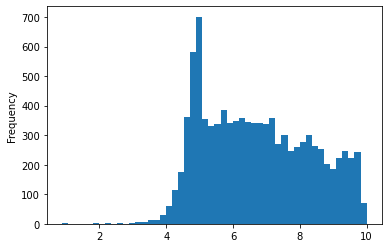

In [115]:
statsec_df['avg(mobiscore)'].plot.hist(bins=50)

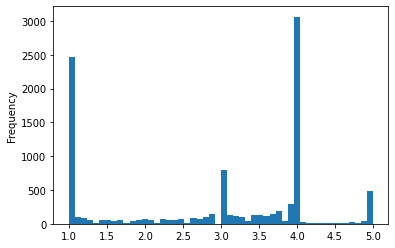

In [116]:
statsec_df['avg(public_transport)'].plot.hist(bins=50)

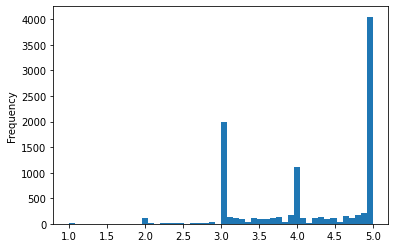

In [117]:
statsec_df['avg(education)'].plot.hist(bins=50)

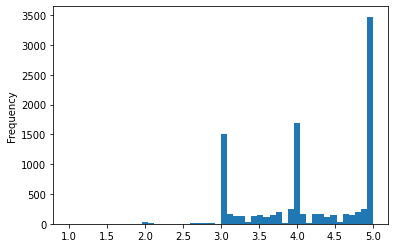

In [121]:
statsec_df['avg(commercial)'].plot.hist(bins=50)

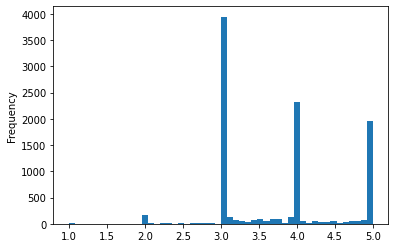

In [122]:
statsec_df['avg(leisure)'].plot.hist(bins=50)

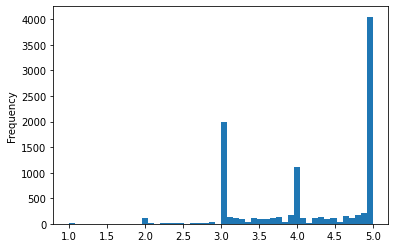

In [124]:
statsec_df['avg(healthcare)'].plot.hist(bins=50)